<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/classificationModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports and Setup
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Modeling Libraries
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Mount Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#  Load Data
file_path = '/content/drive/My Drive/instacart_train_data.pkl'

print(f"Loading data from {file_path}...")
data = pd.read_pickle(file_path)
print(f"Data Loaded Successfully. Shape: {data.shape}")

Loading data from /content/drive/My Drive/instacart_train_data.pkl...
Data Loaded Successfully. Shape: (8474661, 36)


In [3]:
#  Data Preparation & Splitting

#  (Convert to numeric codes for Sklearn)

for col in data.select_dtypes(include=['category', 'object']).columns:
    data[col] = data[col].astype('category').cat.codes

# Define Features (X) and Target (y)
features_to_drop = ['user_id', 'product_id', 'eval_set', 'order_id', 'reordered']
X = data.drop(columns=features_to_drop)
y = data['reordered']
groups = data['user_id'] # for GroupShuffleSplit

#  Splitting (80% Train, 20% Validation)
# This prevents data leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in gss.split(X, y, groups):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")
print(f"Class Imbalance: {y.mean():.2%} of rows are reorders")

# Clean up memory
del data
gc.collect()

Training Set: (6777721, 31)
Validation Set: (1696940, 31)
Class Imbalance: 9.78% of rows are reorders


0

In [4]:
# Evaluation Function
def evaluate_performance(name, y_true, y_pred, y_prob):
    print(f"\n================ {name} PERFORMANCE ================")

    # Standard Metrics
    print(classification_report(y_true, y_pred))

    # ROC AUC
    if y_prob is not None:
        auc = roc_auc_score(y_true, y_prob)
        print(f"ROC AUC Score: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

logestic regression training......

================ Logistic Regression PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.96      0.76      0.85   1531784
           1       0.23      0.69      0.35    165156

    accuracy                           0.75   1696940
   macro avg       0.60      0.72      0.60   1696940
weighted avg       0.89      0.75      0.80   1696940

ROC AUC Score: 0.8038


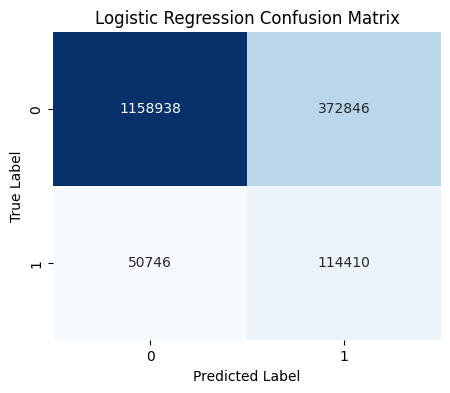

In [5]:
#logestic regression

print("logestic regression training......")

LR_pipline=Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler",StandardScaler()),
    ("model",LogisticRegression(
        penalty='l2',
        C=1.0,
        class_weight='balanced',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    ))
])


LR_pipline.fit(X_train,y_train)

#predction
y_pred_lr = LR_pipline.predict(X_val)
y_prob_lr = LR_pipline.predict_proba(X_val)[:, 1]

evaluate_performance("Logistic Regression", y_val, y_pred_lr, y_prob_lr)

Training Random Forest...

================ Random Forest PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.96      0.75      0.84   1531784
           1       0.24      0.71      0.36    165156

    accuracy                           0.75   1696940
   macro avg       0.60      0.73      0.60   1696940
weighted avg       0.89      0.75      0.80   1696940

ROC AUC Score: 0.8102


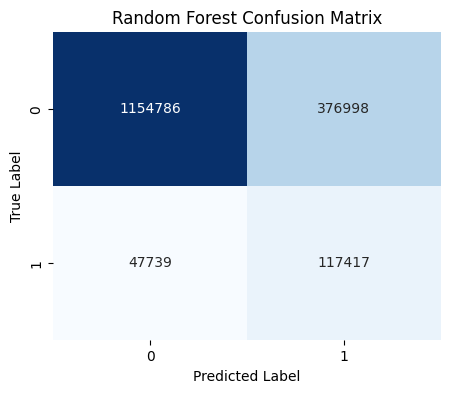

In [6]:
#  Random Forest
print("Training Random Forest...")

# Pipeline
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('model', RandomForestClassifier(
        n_estimators=40,
        max_samples=0.6,
        max_depth=12,
        min_samples_leaf=20,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_pipeline.predict(X_val)
y_prob_rf = rf_pipeline.predict_proba(X_val)[:, 1]

evaluate_performance("Random Forest", y_val, y_pred_rf, y_prob_rf)

Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:23:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Linear SVM...

================ Linear SVM PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.91      0.99      0.95   1531784
           1       0.61      0.09      0.15    165156

    accuracy                           0.91   1696940
   macro avg       0.76      0.54      0.55   1696940
weighted avg       0.88      0.91      0.87   1696940

ROC AUC Score: 0.8016


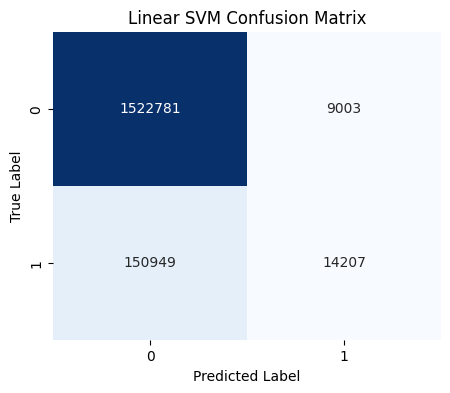


================ XGBoost PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.97      0.73      0.83   1531784
           1       0.23      0.76      0.35    165156

    accuracy                           0.73   1696940
   macro avg       0.60      0.74      0.59   1696940
weighted avg       0.89      0.73      0.78   1696940

ROC AUC Score: 0.8236


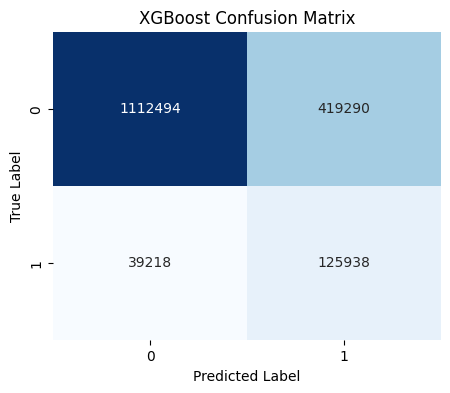

In [7]:
#  XGBoost Classifier
print("Training XGBoost...")

# XGBoost handles NaNs internally, no imputer needed.
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=10, # Handling imbalance (approx ratio 0s/1s)
    n_jobs=-1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)# Cell 8: Linear SVM
print("Training Linear SVM...")

# Pipeline: Mean Impute -> Scale -> Calibrated Linear SVC
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', CalibratedClassifierCV(
        LinearSVC(class_weight='balanced', random_state=42, max_iter=1000),
        method='sigmoid', # To get probability outputs
        cv=3
    ))
])

svm_pipeline.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_pipeline.predict(X_val)
y_prob_svm = svm_pipeline.predict_proba(X_val)[:, 1]

evaluate_performance("Linear SVM", y_val, y_pred_svm, y_prob_svm)

# Predictions
y_pred_xgb = xgb_model.predict(X_val)
y_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]

evaluate_performance("XGBoost", y_val, y_pred_xgb, y_prob_xgb)

Training Decision Tree...

================ Decision Tree PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.96      0.74      0.84   1531784
           1       0.23      0.73      0.35    165156

    accuracy                           0.74   1696940
   macro avg       0.60      0.74      0.60   1696940
weighted avg       0.89      0.74      0.79   1696940

ROC AUC Score: 0.8145


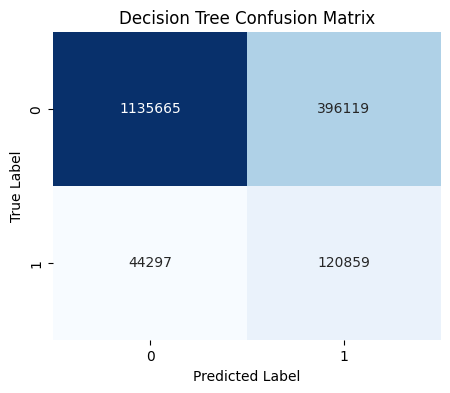

In [8]:
#  Decision Tree Classifier
print("Training Decision Tree...")

dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('model', DecisionTreeClassifier(
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
])

dt_pipeline.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_pipeline.predict(X_val)
y_prob_dt = dt_pipeline.predict_proba(X_val)[:, 1]

evaluate_performance("Decision Tree", y_val, y_pred_dt, y_prob_dt)

Training KNN...

================ KNN (Subset) PERFORMANCE ================
              precision    recall  f1-score   support

           0       0.91      0.98      0.95   1531784
           1       0.37      0.09      0.14    165156

    accuracy                           0.90   1696940
   macro avg       0.64      0.54      0.54   1696940
weighted avg       0.86      0.90      0.87   1696940

ROC AUC Score: 0.6517


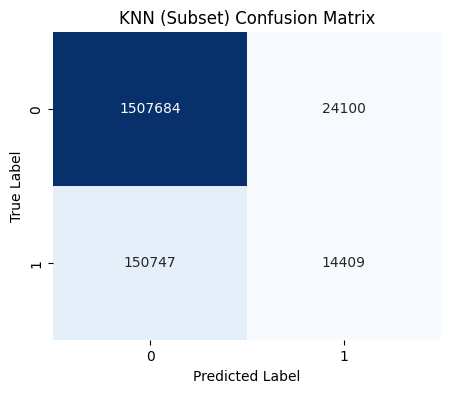

In [9]:
# KNN
print("Training KNN...")

# Create a smaller subset for KNN
subset_size = 50000
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, train_size=subset_size, stratify=y_train, random_state=42
)

knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])

knn_pipeline.fit(X_train_sub, y_train_sub)

# Predictions
y_pred_knn = knn_pipeline.predict(X_val)
y_prob_knn = knn_pipeline.predict_proba(X_val)[:, 1]

evaluate_performance("KNN (Subset)", y_val, y_pred_knn, y_prob_knn)

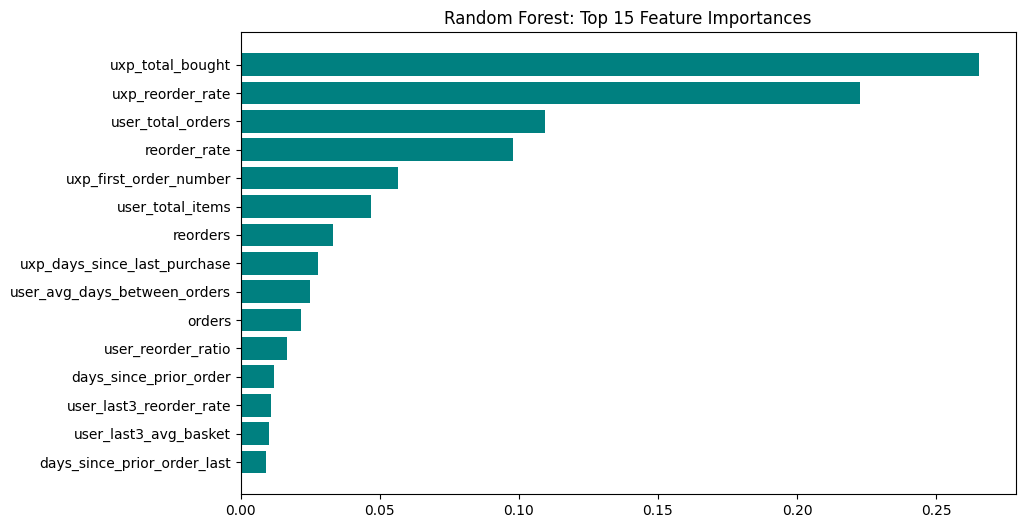

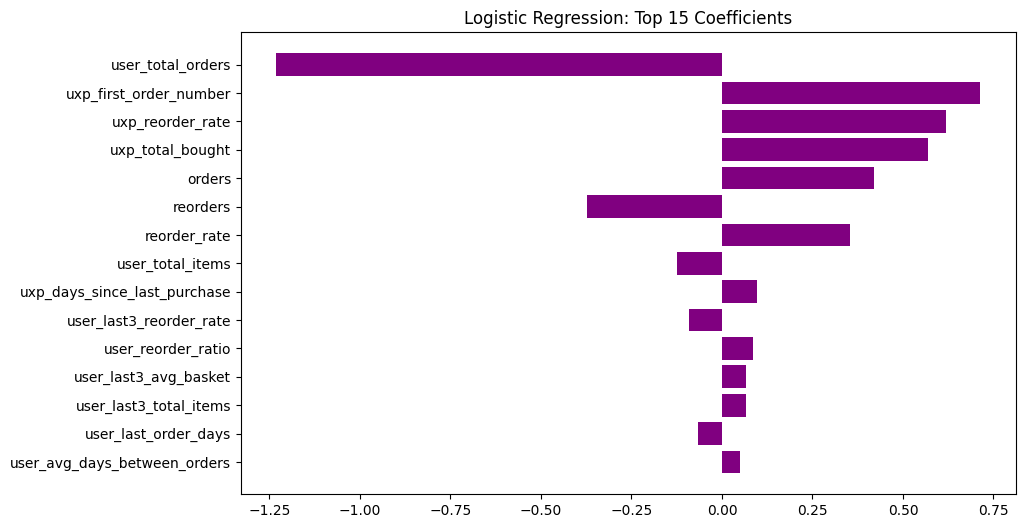

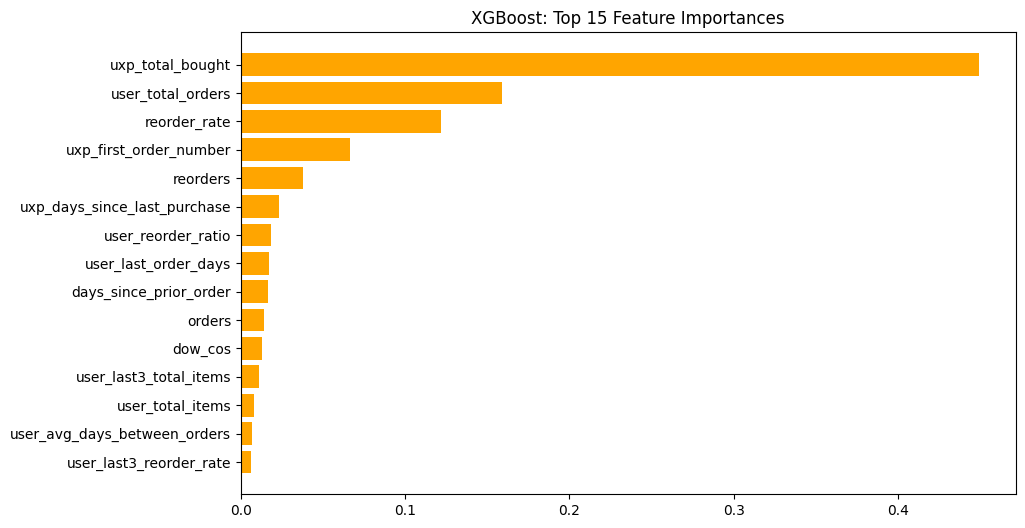

In [12]:
# Feature Importance Visualization

# Random Forest Importances
importances = rf_pipeline.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10, 6))
plt.title("Random Forest: Top 15 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center', color='teal')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.gca().invert_yaxis()
plt.show()

# Logistic Regression Coefficients
coefs = LR_pipline.named_steps['model'].coef_[0]
indices_lr = np.argsort(np.abs(coefs))[::-1][:15]

plt.figure(figsize=(10, 6))
plt.title("Logistic Regression: Top 15 Coefficients")
plt.barh(range(len(indices_lr)), coefs[indices_lr], align='center', color='purple')
plt.yticks(range(len(indices_lr)), [X_train.columns[i] for i in indices_lr])
plt.gca().invert_yaxis()
plt.show()


importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1][:15]

plt.figure(figsize=(10, 6))
plt.title("XGBoost: Top 15 Feature Importances")
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center', color='orange')
plt.yticks(range(len(indices_xgb)), [X_train.columns[i] for i in indices_xgb])
plt.gca().invert_yaxis()
plt.show()